`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   

# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. 

*Модели*: множественная линейная регрессия 
*Данные*: `winequality-white_for_lab` (источник: https://github.com/ania607/ML/blob/main/data/winequality-white_for_lab.csv)

## Загружаем пакеты

In [77]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [78]:
# константы
# ядро для генератора случайных чисел
my_seed = 14
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков: 
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set3")

In [79]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
# из репозитория к книге С.Рашки Python и машинное обучение,
# слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## Загружаем данные

`winequality-white_for_lab` – преобразованные наборы данных со статистикой по качеству белых вин. Источник: сайт Калифорнийского университета в Ирвине.
Набор в формате csv доступен по ссылке: https://raw.githubusercontent.com/ania607/ML/main/data/winequality-white_for_lab.csv

## Список столбцов файла:   

* `fixed_acidity` – постоянная кислотность;  
* `volatile_acidity` – переменная кислотность;  
* `citric_acid` – содержание лимонной кислоты;  
* `residual_sugar` – остаточный сахар;  
* `chlorides` – содержание хлоридов;  
* `free_sulfur_dioxide` – содержание диоксида серы в свободном виде;  
* `total_sulfur_dioxide` – общее содержание диоксида серы;  
* `density` – плотность;  
* `pH` – кислотность; 
* `sulphates` – содержание сульфатов;  
* `alcohol` – содержание алкоголя;  
* `quality` – балльная оценка качества вина, от 0 до 10;  
* `Y` – целевая переменная: 1 = высокое качество (`quality` > 5), 0 = низкое (`quality` <= 5).    

Загружаем данные во фрейм и выясняем их размерность.  

In [80]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv'
DF_all = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


Отложим 15% наблюдений для прогноза.  

In [81]:
# наблюдения для моделирования
DF = DF_all.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [82]:
# первые 5 строк фрейма
DF.iloc[:, :].head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
6947,150000,1,3,1,64,0,0,0,0,0,...,60304,61650,0,2688,2730,2680,2850,0,0,0
24408,620000,1,2,1,42,0,0,0,0,0,...,60479,61467,63159,3500,2500,2500,2300,3000,2500,0
11085,180000,2,2,2,34,0,0,0,0,0,...,63249,51437,45279,3000,3000,33000,2000,2000,2000,0
21625,80000,2,2,2,24,0,0,0,0,0,...,3210,1651,2256,1500,1511,1000,1000,2256,924,0
3207,390000,1,1,2,34,-1,-1,-1,-1,-1,...,7957,3044,27603,524,1790,7957,3044,27603,11219,0


In [83]:
# типы столбцов фрейма
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [84]:
# считаем пропуски в каждом столбце
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

Пропусков не обнаружено.  

# Предварительный анализ данных  

## Описательные статистики  

Считаем доли классов целевой переменной `Y`.  

In [85]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [86]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 5)

0    0.77749
1    0.22251
Name: Y, dtype: float64

Все объясняющие переменные набора данных непрерывные. Рассчитаем для них описательные статистики.  

In [87]:
# описательные статистики
DF.iloc[:, :13].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,167563.516863,1.602392,1.854824,1.551333,35.469882,-0.018706,-0.133294,-0.165137,-0.220510,-0.263882,-0.290353,51308.949882,49177.609843
std,129692.809865,0.489413,0.791057,0.521990,9.210737,1.124963,1.199107,1.200703,1.173773,1.142866,1.157475,73604.276685,71131.938113
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3555.750000,2946.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22439.000000,21200.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67374.000000,64027.250000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000


In [88]:
# описательные статистики
DF.iloc[:, 11:23].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000
mean,51308.949882,49177.609843,4.700741e+04,43177.714392,40194.415451,38775.580980,5640.161451,5.905967e+03,5169.580157,4812.683451,4747.400118,5129.736980
std,73604.276685,71131.938113,6.935177e+04,64408.990455,60732.087927,59536.248091,16772.902744,2.379707e+04,17864.453910,15607.831191,15252.544831,16762.422079
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3555.750000,2946.000000,2.617750e+03,2294.000000,1727.750000,1242.000000,991.000000,8.167500e+02,390.000000,291.000000,241.750000,102.000000
50%,22439.000000,21200.000000,2.005150e+04,18991.000000,18067.000000,17008.500000,2100.000000,2.008000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,67374.000000,64027.250000,6.025250e+04,54275.000000,50141.750000,49110.500000,5006.000000,5.000000e+03,4500.000000,4009.250000,4002.000000,4000.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,443001.000000


Выводы по описательным статистикам: значения объясняющих переменных положительные, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Визуализация разброса переменных внутри классов  

Поскольку в наборе данных 23 объясняющих переменных, и все они непрерывные, анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

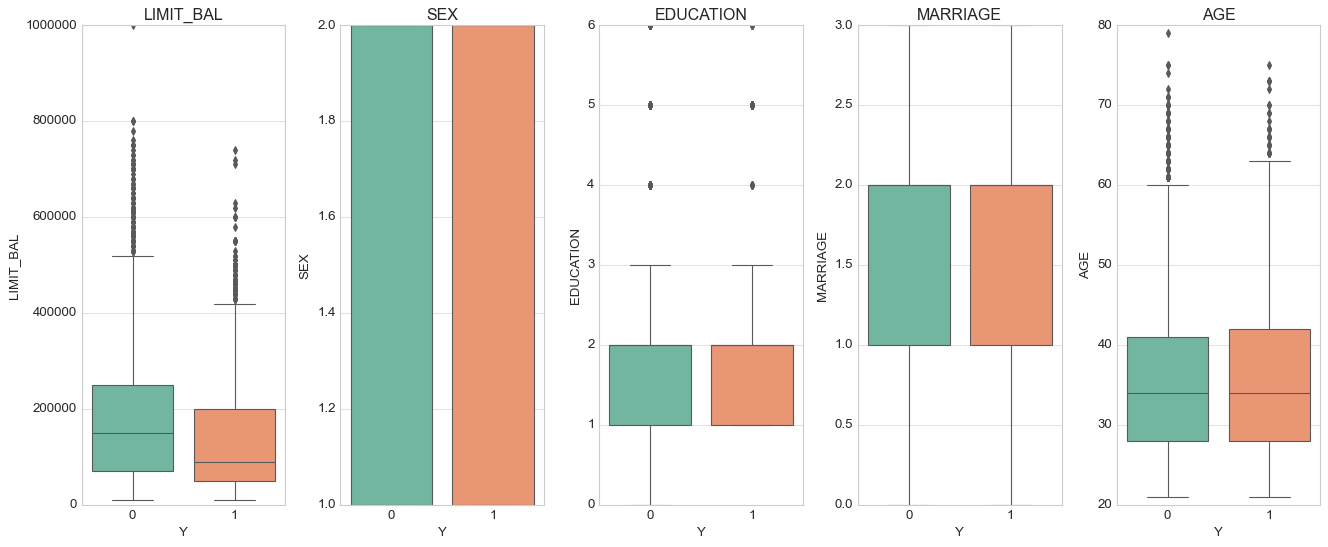

In [89]:
# создаём полотно и делим его на пять части
fig = plt.figure(figsize=(20, 7))
gs = mpl.gridspec.GridSpec(1, 6)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

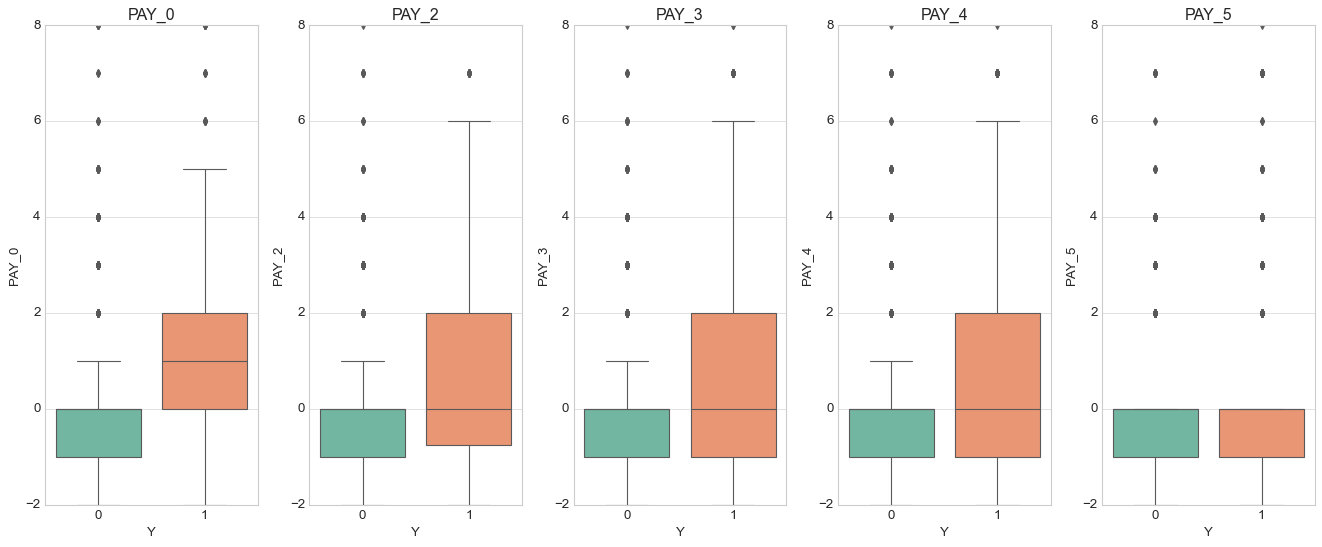

In [90]:
# создаём полотно и делим его на пять части
fig = plt.figure(figsize=(20, 7))
gs = mpl.gridspec.GridSpec(1, 6)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[5:10].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

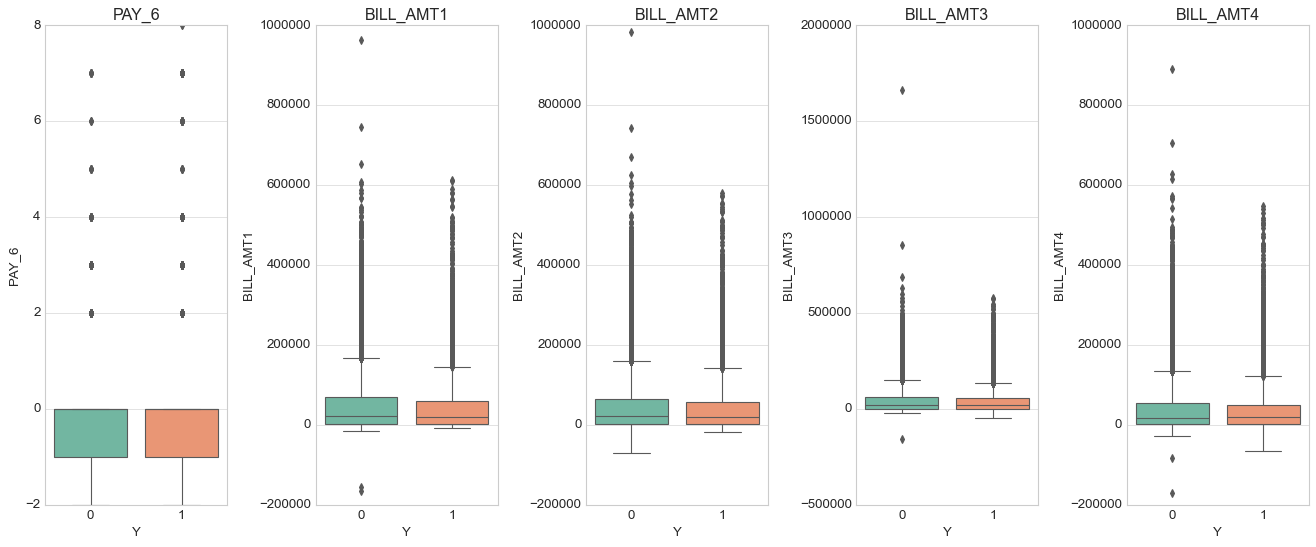

In [91]:
# создаём полотно и делим его на пять части
fig = plt.figure(figsize=(20, 7))
gs = mpl.gridspec.GridSpec(1, 6)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[10:15].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

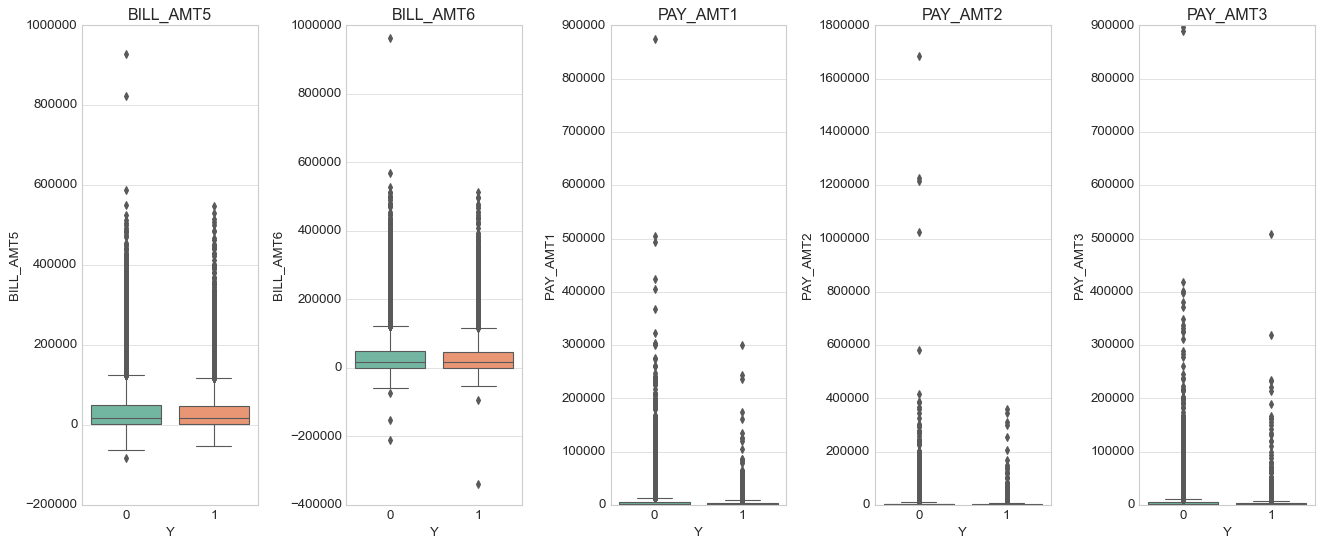

In [92]:
# создаём полотно и делим его на пять части
fig = plt.figure(figsize=(20, 7))
gs = mpl.gridspec.GridSpec(1, 6)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[15:20].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

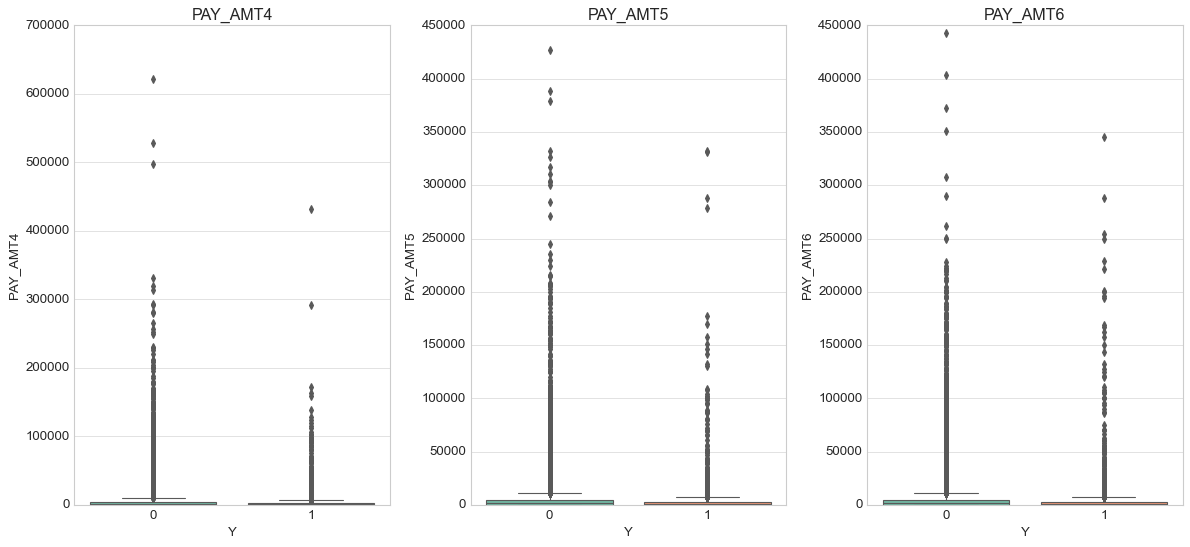

In [93]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(20, 7))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])


axs = [ax1, ax2, ax3]

cols_loop = list(DF.columns[20:23].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в медианах и разбросе между классами прослеживается практически по всем объясняющим переменным.
Это говорит о том, классы по зависимой переменной `Y` неплохо разделяются по всем объясняющим переменным.  

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

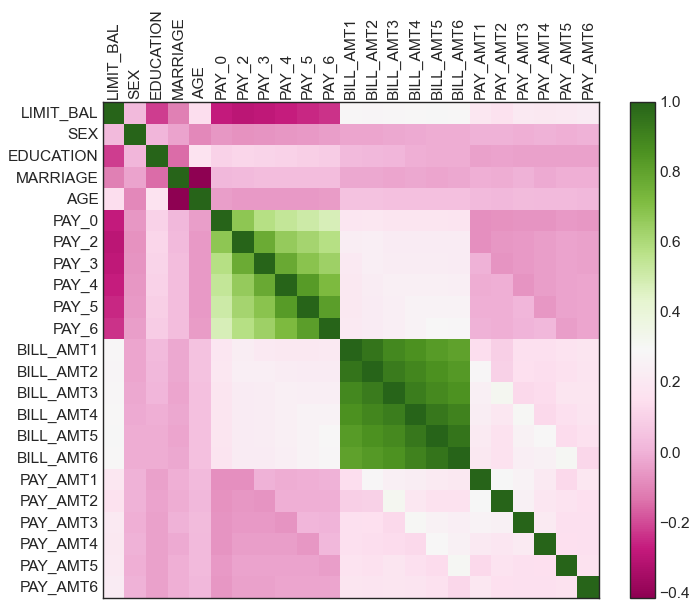

In [94]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.     

In [95]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
63,MARRIAGE,AGE,-0.415174,0.0
5,LIMIT_BAL,PAY_2,-0.298175,0.0
6,LIMIT_BAL,PAY_3,-0.284894,0.0
4,LIMIT_BAL,PAY_0,-0.273330,0.0
7,LIMIT_BAL,PAY_4,-0.268101,0.0
...,...,...,...,...
208,BILL_AMT3,BILL_AMT4,0.920838,0.0
198,BILL_AMT2,BILL_AMT3,0.926879,0.0
217,BILL_AMT4,BILL_AMT5,0.939132,0.0
225,BILL_AMT5,BILL_AMT6,0.947337,0.0


# Методы снижения резмерности  

Посмотрим, как работают метод снижения размерности:  

* частный метод наименьших квадратов (PLS)    

Метод требует предварительной стандартизации переменных.  

In [96]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :23].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1: среднее = -0.0   Станд. отклонение = 1.0
Столбец 2: среднее = -0.0   Станд. отклонение = 1.0
Столбец 3: среднее = 0.0   Станд. отклонение = 1.0
Столбец 4: среднее = -0.0   Станд. отклонение = 1.0
Столбец 5: среднее = -0.0   Станд. отклонение = 1.0
Столбец 6: среднее = 0.0   Станд. отклонение = 1.0
Столбец 7: среднее = -0.0   Станд. отклонение = 1.0
Столбец 8: среднее = 0.0   Станд. отклонение = 1.0
Столбец 9: среднее = -0.0   Станд. отклонение = 1.0
Столбец 10: среднее = -0.0   Станд. отклонение = 1.0
Столбец 11: среднее = -0.0   Станд. отклонение = 1.0
Столбец 12: среднее = 0.0   Станд. отклонение = 1.0
Столбец 13: среднее = -0.0   Станд. отклонение = 1.0
Столбец 14: среднее = -0.0   Станд. отклонение = 1.0
Столбец 15: среднее = 0.0   Станд. отклонение = 1.0
Столбец 16: среднее = -0.0   Станд. отклонение = 1.0
Столбец 17: среднее = 0.0   Станд. отклонение = 1.0
Столбец 18: среднее = 0.0   Станд. отклонение = 1.0
Столбец 19

## Метод частных наименьших квадратов
Сначала посмотрим, как работает метод на всех наблюдениях обучающего набора. 

In [97]:
# функция для оценки модели, берём все компоненты, по числу столбцов X
pls=PLSRegression(n_components=23)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train=pd.get_dummies(DF[['Y']].astype(str))
# оцениваем
pls.fit(X_train_std,Y_train)

# считаем долю объяснённой дисперсии
frac_var_expl=np.var(pls.x_scores_,axis=0)/np.sum(np.var(X_train_std,axis=0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',np.around(frac_var_expl,3),
      '\nОбщая сумма долей:',np.around(sum(frac_var_expl),3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.183 0.144 0.059 0.044 0.025 0.028 0.016 0.026 0.008 0.025 0.014 0.009
 0.023 0.006 0.019 0.007 0.021 0.006 0.013 0.012 0.032 0.002 0.022] 
Общая сумма долей: 0.744


Из-за того, что при вычислении компонент метдом PLS мы учитываем корреляцию с $Y$ компоненты, во-первых, не ортогональны, а во-вторых сумма объяснённых долей дисперсии уже не равняется 1.  

In [98]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components = 2)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.720952,0.279048
1,0.808313,0.191687
2,0.780069,0.219931
3,0.744671,0.255329
4,0.899033,0.100967
...,...,...
25495,0.724312,0.275688
25496,0.692316,0.307684
25497,0.827593,0.172407
25498,0.788455,0.211545


In [99]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred : 
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# Y_train_hat
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(0, 24592), (1, 908)])

Рисуем классы на графике в координатах 2 главных компонент по PLS. 

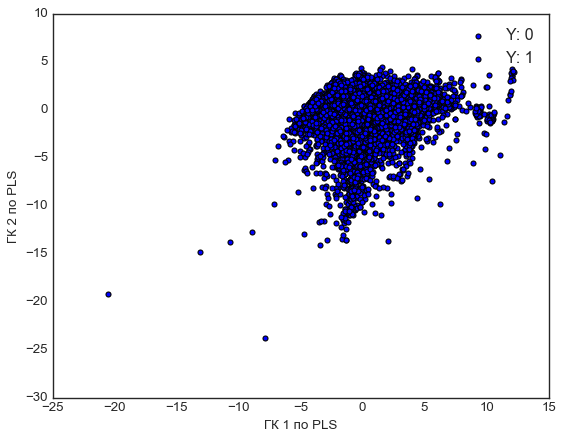

In [100]:
# график классов в пространстве ГК
plt.scatter(X_train_pls[DF['Y'] == 0][:, 0], 
            X_train_pls[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pls[DF['Y'] == 1][:, 0], 
            X_train_pls[DF['Y'] == 1][:, 1], label='Y: 1')
plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

Судя по графику, классы совсем не разделяются в пространстве двух главных компонент. Построим логистическую регрессию и оценим её точность с помощью перекрёстной проверки.  

In [107]:
# функция разбиения на блоки для перекрёстной проверки
#  для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
#  функция cross_val_score не сработает, т.к. у нас мультиклассовая
#  классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=2)
# для записи Acc по блокам
acc_blocks = list()
# цикл по блокам
for train_index, test_index in kf_10.split(X_train_std, DF.Y.values) : 
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]

    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]

    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred : 
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)
score = list()
score.append(np.around(np.mean(acc_blocks), 3))
score_models = list()
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 0.79


# Методы сжатия  
 

## Лассо-регрессия

Технически реализация лассо-регрессии отличается от ридж единственным аргументом `penalty='l1'` в функции `LogisticRegression`.    

In [108]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [-1.452] 
Коэффициенты моделей для классов:
 [[-0.105 -0.056 -0.077 -0.08   0.07   0.636  0.098  0.089  0.024  0.035
   0.022 -0.399  0.164  0.112  0.023  0.009  0.002 -0.251 -0.206 -0.04
  -0.041 -0.033 -0.032]]


In [109]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
lasso_cv = LogisticRegressionCV(cv=10, random_state=my_seed+3,
                               penalty='l1', solver='liblinear')
lasso_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
lasso_cv.C_

array([0.35938137])

In [110]:
# сохраняем и выводим Acc для модели
score.append(np.around(lasso_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_lasso')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_lasso, перекрёстная проверка по 10 блокам
Acc = 0.81


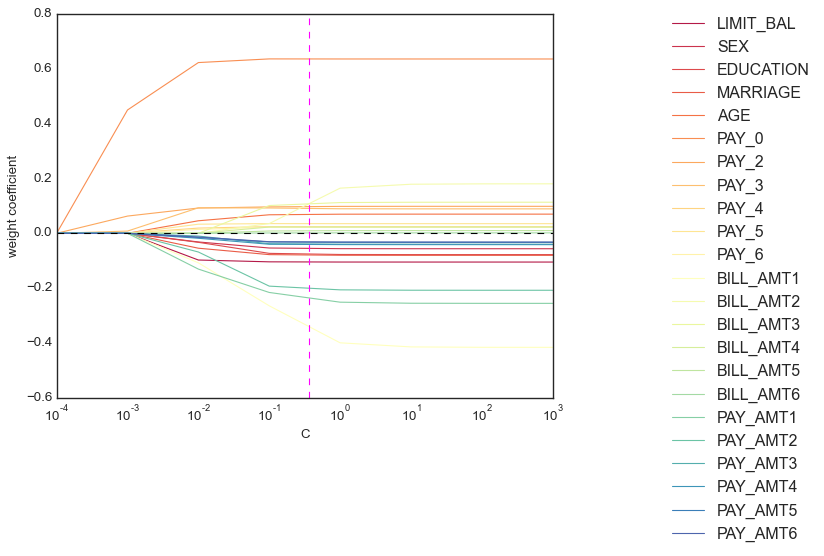

In [114]:
# график динамики коэффициентов в лассо-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l1', lasso_cv.C_, DF.columns)

Итак, судя по графику, для значения гиперпараметра, дающего самую точную модель, ни один коэффициент при объясняющих переменных не обнуляется. Это подтверждает наблюдение, сделанное нами ещё на этапе предварительного анализа: все объясняющие переменные неплохо разделяют классы.   


# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенной модели.  

In [121]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PLS,0.793
1,logit_lasso,0.810


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается лассо-регрессия. Сделаем прогноз на отложенные наблюдения.   

In [127]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :23].values)
Y_pred = DF_predict.Y
Y_hat = logit_lasso.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3538
           1       0.70      0.24      0.35       962

    accuracy                           0.82      4500
   macro avg       0.76      0.60      0.62      4500
weighted avg       0.80      0.82      0.78      4500



Итак, методом логистической регрессии со сжатием коэффициенты с L2-регуляризацией мы получили идеально точную модель классификации трёх видов красных вин.  

# Источники 

1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. Репозиторий с кодом к книге *Рашка С.* Python и машинное обучение / github.com. URL: <https://github.com/rasbt/python-machine-learning-book-3rd-edition>  
1. *Xueting Bai*, *Lingbo Wang*, *Hanning Li* Identification of red wine categories based on physicochemical properties / 2019 5th International Conference on Education Technology, Management and Humanities Science (ETMHS 2019). URL: <https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf>  

